# Setup Environment

In [3]:
import pandas as pd
import torch
import numpy as np

from transformers import (
    pipeline,
    AutoTokenizer,
    AutoModelForSeq2SeqLM,
    AutoModelForCausalLM,
    BartTokenizer,
)

from transformers import T5Tokenizer, T5ForConditionalGeneration
from transformers import PegasusForConditionalGeneration, PegasusTokenizer

C:\Users\youse\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
!pip install sentencepiece
!pip install transformers
!pip install einops
!pip install rouge

# Import Data

In [2]:
df = pd.read_csv(
    "https://github.com/AnasElbattra/News-Understanding-NLP/raw/main/Summarization/Data/MahendrakharraBBC-News-Articles-Summaries/train.csv"
)
df

,articles,summaries
0,Faith schools citizenship warningSchools must ...,"Mr Bell said Muslim, Jewish and Evangelical Ch..."
1,Leaders meet over Turkish EU bidTony Blair has...,Mr Blair is an enthusiastic proponent of talks...
2,Guantanamo pair's passport banThe government h...,"The men's solicitor, Louise Christian, has rai..."
3,Terror powers expose 'tyranny'The Lord Chancel...,"Mr Forsyth links ""Islamic fundamentalism"" to t..."
4,Gurkhas to help tsunami victimsBritain has off...,Britain has offered to send a company of 120 G...
...,...,...
1795,London hope over ChepkemeiLondon Marathon orga...,London Marathon organisers are hoping that ban...
1796,Wilkinson return 'unlikely'Jonny Wilkinson loo...,"Despite not playing for England, Wilkinson is ..."
1797,Klinsmann issues Lehmann warningGermany coach ...,"Klinsmann added: ""If he is not playing regular..."
1798,Tomlinson stays focused on EuropeLong jumper C...,"The Birmingham athlete, who clocked a season's..."


# Models

In [36]:
flan_t5_base = "ybagoury/flan-t5-base-tldr_news"
bart_large = "facebook/bart-large-cnn"
pegasus = "google/pegasus-large"

bart_tokenizer = BartTokenizer.from_pretrained("facebook/bart-large")
t5_tokenizer = T5Tokenizer.from_pretrained("google/flan-t5-base")
pegasus_tokenizer = AutoTokenizer.from_pretrained("google/pegasus-large")

bart_summ = pipeline("summarization", model=bart_large, tokenizer=bart_tokenizer)
t5_summ = pipeline("summarization", model=flan_t5_base, tokenizer=t5_tokenizer)
pegasus_summ = pipeline("summarization", model=pegasus, tokenizer=pegasus_tokenizer)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at google/pegasus-large and are newly initialized: ['model.encoder.embed_positions.weight', 'model.decoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [33]:
def getSummary_chunks(text, summarizer_model, max_chunk_length=500):
    # input_ids = tokenizer.encode(text, return_tensors="pt")

    # # Generate Summary Text Ids
    # summary_text_ids = model_summarize.generate(
    #     input_ids=input_ids,
    #     bos_token_id=model_summarize.config.bos_token_id,
    #     eos_token_id=model_summarize.config.eos_token_id,
    #     length_penalty=2.0,
    #     max_length=142,
    #     min_length=30,
    #     num_beams=4,
    # )

    # text_summarized=summary_text_ids[0]
    # print(tokenizer.decode(text_summarized, skip_special_tokens=True))
    text_chunks = [
        text[i : i + max_chunk_length] for i in range(0, len(text), max_chunk_length)
    ]

    # Generate summaries for each chunk
    chunk_summaries = [
        summarizer_model(chunk)[0]["summary_text"] for chunk in text_chunks
    ]

    # Concatenate the chunk summaries to get the final summary
    text_summarized = " ".join(chunk_summaries)

    return text_summarized

In [38]:
def getSummary(text, summarizer_model):
    # Generate summary for the entire text
    summary = summarizer_model(text, length_penalty=2.0, num_beams=4)[0]["summary_text"]

    return summary

In [5]:
text = """When most presidents in the past have sent a message leading into the new year, they ve sent messages of hope, unity, and a better tomorrow. Clearly, President-elect Donald Trump is not trying to be like any former leader.Trump s New Year s Eve message, sent via his medium of choice   Twitter   went something like this: Happy New Year to all, including to my many enemies and those who have fought me and lost so badly they just don t know what to do. Love! Happy New Year to all, including to my many enemies and those who have fought me and lost so badly they just don't know what to do. Love!  Donald J. Trump (@realDonaldTrump) December 31, 2016This narcissistic message was clearly not about the nation or bringing us to together in any sort of way, but instead throws over half the nation under the bus.However, if one were to redact most of Trump s tweets and just leave the intro and the close, it would sound something like this: Happy New Year to all. Love! Redacted, Trump sounds just like Obama! ? pic.twitter.com/h9W5JbqE98  Sarah Wood (@SarahWoodwriter) December 31, 2016Which, quite honestly, sounds like someone who wants to unite the nation and move forward towards a better tomorrow. It actually sounds remarkably like the president we ve had for the past eight years, President Barack Obama.If only Trump could contain his narcissistic animosity towards those who don t like him or agree with him. However, his fragile ego doesn t seem to make that possible thus his constant Twitter fits of rage against anyone who dare speak against him.Redacted Trump could actually be a good leader. Unfortunately, he doesn t seem to know how to edit himself for the greater good. Hopefully that will change.Featured Photo by Chip Somodevilla, Twitter/Getty Images
"""
reference_summary = """President-elect Donald Trump's New Year's Eve message on Twitter was criticized for being narcissistic and not promoting unity or hope. If redacted, Trump's message would sound more like President Barack Obama, aiming to unite the nation and move towards a better tomorrow. However, Trump's fragile ego makes it difficult for him to edit himself for the greater good.
"""

In [6]:
print("Flan T5 Base summarization: \n")
t5_summarized = getSummary(text, t5_summ)
print(t5_summarized)

Flan T5 Base summarization: 

Donald Trump’s New Year s Eve message is a narcissistic one, and he’s not trying to be like any former leader


In [27]:
# generate summaries with bart on the dataset
df["bart_summ"] = df["articles"].apply(lambda x: getSummary(x, bart_summ))

Your max_length is set to 100, but your input_length is only 98. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=49)
Your max_length is set to 100, but your input_length is only 96. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=48)
Your max_length is set to 100, but your input_length is only 95. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=47)
Your max_length is set to 100, but your input_length is only 90. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=45)
Your

In [7]:
# take 1000 samples from the dataset
df_sample = df.sample(1000)

In [10]:
# generate summaries with t5 on the dataset
df_sample["t5_summ"] = df_sample["articles"].apply(lambda x: getSummary(x, t5_summ))

Token indices sequence length is longer than the specified maximum sequence length for this model (548 > 512). Running this sequence through the model will result in indexing errors
Your max_length is set to 142, but your input_length is only 117. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=58)


In [20]:
raw_document = """When most presidents in the past have sent a message leading into the new year, they ve sent messages of hope, unity, and a better tomorrow. Clearly, President-elect Donald Trump is not trying to be like any former leader.Trump s New Year s Eve message, sent via his medium of choice   Twitter   went something like this: Happy New Year to all, including to my many enemies and those who have fought me and lost so badly they just don t know what to do. Love! Happy New Year to all, including to my many enemies and those who have fought me and lost so badly they just don't know what to do. Love!  Donald J. Trump (@realDonaldTrump) December 31, 2016This narcissistic message was clearly not about the nation or bringing us to together in any sort of way, but instead throws over half the nation under the bus.However, if one were to redact most of Trump s tweets and just leave the intro and the close, it would sound something like this: Happy New Year to all. Love! Redacted, Trump sounds just like Obama! ? pic.twitter.com/h9W5JbqE98  Sarah Wood (@SarahWoodwriter) December 31, 2016Which, quite honestly, sounds like someone who wants to unite the nation and move forward towards a better tomorrow. It actually sounds remarkably like the president we ve had for the past eight years, President Barack Obama.If only Trump could contain his narcissistic animosity towards those who don t like him or agree with him. However, his fragile ego doesn t seem to make that possible thus his constant Twitter fits of rage against anyone who dare speak against him.Redacted Trump could actually be a good leader. Unfortunately, he doesn t seem to know how to edit himself for the greater good. Hopefully that will change.Featured Photo by Chip Somodevilla, Twitter/Getty Images
"""
prompt = "Produce an article summary of the following news article:"
results = t5_summ_3b(
    f"{prompt} {raw_document}",
    num_beams=5,
    min_length=5,
    no_repeat_ngram_size=3,
    truncation=True,
    max_length=512,
)
print(results)

Your max_length is set to 512, but your input_length is only 456. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=228)


[{'summary_text': "President-elect Donald Trump sent a narcissistic message on New Year's Eve . Redacted, Trump sounds just like President Barack Obama . Trump's message was clearly not about the nation or bringing us to together ."}]


In [11]:
df_sample

,articles,summaries,t5_summ
1012,S Korea spending boost to economySouth Korea w...,"""The focus will be on job creation and economi...",South Korea to boost spending next year to cre...
1185,Slowdown hits US factory growthUS industrial p...,"""February was another good month in the manufa...",U.S. industrial output rises for 21st month in...
198,Anti-terror plan faces first testPlans to allo...,Mr Clarke says he does not intend to use the h...,Home Secretary Charles Clarke says he doesn't ...
1169,Barclays shares up on merger talkShares in UK ...,Shares in UK banking group Barclays have risen...,Barclays shares rise after weekend report that...
1181,Building giant in asbestos payoutAustralian bu...,"In 2001, the company set up a fund to compensa...",Building giant James Hardie agrees to pay $1.1...
...,...,...,...
596,TV show unites Angolan familiesAngolan familie...,"The media in the southern African country, twi...",A hugely popular TV show has reunited hundreds...
382,Whitehall cuts 'ahead of target'Thousands of c...,"In his Budget statement, the chancellor said t...",Thousands of civil service jobs have been cut ...
802,Snow Patrol bassist exits groupSnow Patrol had...,"Snow Patrol had ""no other course of action"" bu...",Snow Patrol co-founder and bassist Mark McClel...
617,Da Vinci Code is 'lousy history'The plot of an...,Despite enjoying Dan Brown's conspiracy theory...,"The Da Vinci Code is 'lousy history', a clergy..."


In [15]:
from bert_score import score
from tqdm import tqdm
import numpy as np

# Create columns for precision, recall, and F1 score
df_sample["bert_precision"] = np.nan
df_sample["bert_recall"] = np.nan
df_sample["bert_f1"] = np.nan

for i, row in tqdm(df_sample.iterrows(), total=len(df_sample)):
    precision, recall, f1 = score(
        [row["t5_summ"]], [row["summaries"]], lang="en", verbose=False
    )
    df_sample.at[i, "bert_precision"] = precision.item()
    df_sample.at[i, "bert_recall"] = recall.item()
    df_sample.at[i, "bert_f1"] = f1.item()

  0%|          | 0/1000 [00:00<?, ?it/s]Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
  0%|          | 1/1000 [00:02<38:41,  2.32s/it]Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
  0%|          | 2/1000 [00:04<35:29,  2.13s/it]Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and

In [21]:
# change bert_precision, bert_recall, and bert_f1 t5_precision, t5_recall, and t5_f1
df_sample.rename(
    columns={
        "bert_precision": "t5_precision",
        "bert_recall": "t5_recall",
        "bert_f1": "t5_f1",
    },
    inplace=True,
)

In [5]:
df_sample

,articles,summaries,t5_summ,t5_precision,t5_recall,t5_f1
0,S Korea spending boost to economySouth Korea w...,"""The focus will be on job creation and economi...",South Korea to boost spending next year to cre...,0.900553,0.829235,0.863424
1,Slowdown hits US factory growthUS industrial p...,"""February was another good month in the manufa...",U.S. industrial output rises for 21st month in...,0.876172,0.821718,0.848072
2,Anti-terror plan faces first testPlans to allo...,Mr Clarke says he does not intend to use the h...,Home Secretary Charles Clarke says he doesn't ...,0.916732,0.815676,0.863256
3,Barclays shares up on merger talkShares in UK ...,Shares in UK banking group Barclays have risen...,Barclays shares rise after weekend report that...,0.910849,0.812494,0.858865
4,Building giant in asbestos payoutAustralian bu...,"In 2001, the company set up a fund to compensa...",Building giant James Hardie agrees to pay $1.1...,0.913028,0.846419,0.878462
...,...,...,...,...,...,...
995,TV show unites Angolan familiesAngolan familie...,"The media in the southern African country, twi...",A hugely popular TV show has reunited hundreds...,0.850907,0.806073,0.827884
996,Whitehall cuts 'ahead of target'Thousands of c...,"In his Budget statement, the chancellor said t...",Thousands of civil service jobs have been cut ...,0.893641,0.841107,0.866578
997,Snow Patrol bassist exits groupSnow Patrol had...,"Snow Patrol had ""no other course of action"" bu...",Snow Patrol co-founder and bassist Mark McClel...,0.895668,0.833395,0.863410
998,Da Vinci Code is 'lousy history'The plot of an...,Despite enjoying Dan Brown's conspiracy theory...,"The Da Vinci Code is 'lousy history', a clergy...",0.877299,0.830222,0.853112


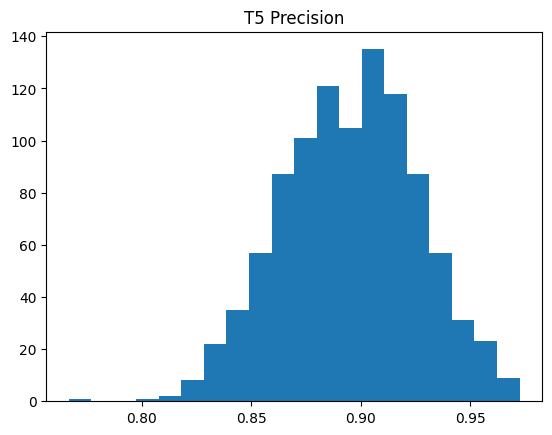

In [6]:
# plot the t5_precision, t5_recall, and t5_f1 scores
import matplotlib.pyplot as plt

plt.hist(df_sample["t5_precision"], bins=20)
plt.title("T5 Precision")
plt.show()

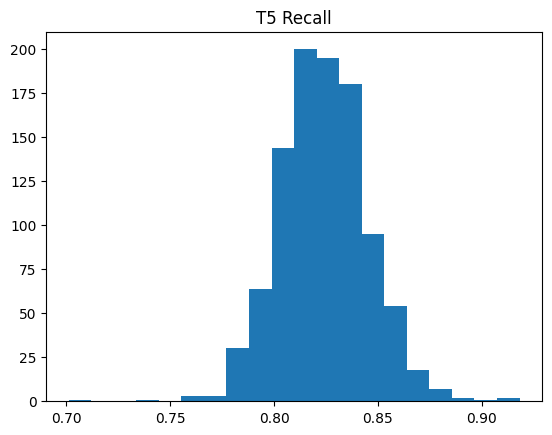

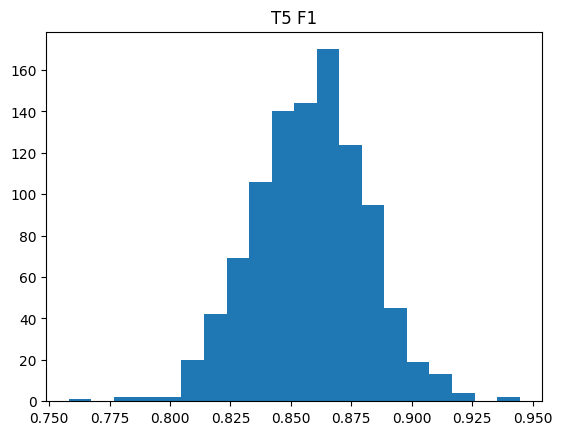

In [7]:
plt.hist(df_sample["t5_recall"], bins=20)
plt.title("T5 Recall")
plt.show()

plt.hist(df_sample["t5_f1"], bins=20)
plt.title("T5 F1")
plt.show()

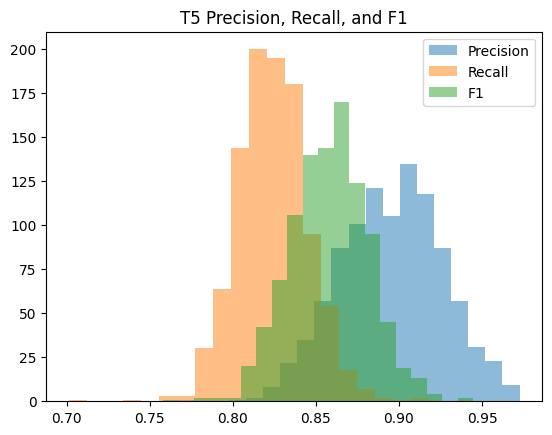

In [8]:
# plot the t5_precision, t5_recall, and t5_f1 scores in the same plot
plt.hist(df_sample["t5_precision"], bins=20, alpha=0.5, label="Precision")
plt.hist(df_sample["t5_recall"], bins=20, alpha=0.5, label="Recall")
plt.hist(df_sample["t5_f1"], bins=20, alpha=0.5, label="F1")
plt.legend(loc="upper right")
plt.title("T5 Precision, Recall, and F1")
plt.show()

In [23]:
df_sample.to_csv("t5_bert_score.csv", index=False)

In [4]:
df_sample = pd.read_csv(
    "https://github.com/AnasElbattra/News-Understanding-NLP/raw/main/Summarization/Data/t5_bert_score.csv"
)

In [15]:
# generate summaries with bart on the dataset
df_sample["bart_summ"] = df_sample["articles"].apply(
    lambda x: getSummary_chunks(x, bart_summ)
)

Your max_length is set to 100, but your input_length is only 99. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=49)
Your max_length is set to 100, but your input_length is only 99. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=49)
Your max_length is set to 100, but your input_length is only 99. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=49)
Your max_length is set to 100, but your input_length is only 19. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=9)
Your 

In [17]:
df_sample.to_csv("t5_bart.csv", index=False)

In [18]:
df_sample

,articles,summaries,t5_summ,t5_precision,t5_recall,t5_f1,bart_summ
0,S Korea spending boost to economySouth Korea w...,"""The focus will be on job creation and economi...",South Korea to boost spending next year to cre...,0.900553,0.829235,0.863424,S Korea earmarks 100 trillion won ($96bn) for ...
1,Slowdown hits US factory growthUS industrial p...,"""February was another good month in the manufa...",U.S. industrial output rises for 21st month in...,0.876172,0.821718,0.848072,The Institute for Supply Management (ISM) inde...
2,Anti-terror plan faces first testPlans to allo...,Mr Clarke says he does not intend to use the h...,Home Secretary Charles Clarke says he doesn't ...,0.916732,0.815676,0.863256,"Tories, Lib Dems and some Labour MPs are poise..."
3,Barclays shares up on merger talkShares in UK ...,Shares in UK banking group Barclays have risen...,Barclays shares rise after weekend report that...,0.910849,0.812494,0.858865,Shares in UK banking group Barclays have risen...
4,Building giant in asbestos payoutAustralian bu...,"In 2001, the company set up a fund to compensa...",Building giant James Hardie agrees to pay $1.1...,0.913028,0.846419,0.878462,The landmark deal could see thousands of peopl...
...,...,...,...,...,...,...,...
995,TV show unites Angolan familiesAngolan familie...,"The media in the southern African country, twi...",A hugely popular TV show has reunited hundreds...,0.850907,0.806073,0.827884,Meeting Point has become one of TV Angola's mo...
996,Whitehall cuts 'ahead of target'Thousands of c...,"In his Budget statement, the chancellor said t...",Thousands of civil service jobs have been cut ...,0.893641,0.841107,0.866578,"Chancellor Gordon Brown said 12,500 jobs had g..."
997,Snow Patrol bassist exits groupSnow Patrol had...,"Snow Patrol had ""no other course of action"" bu...",Snow Patrol co-founder and bassist Mark McClel...,0.895668,0.833395,0.863410,Mark McClelland had been in the band for more ...
998,Da Vinci Code is 'lousy history'The plot of an...,Despite enjoying Dan Brown's conspiracy theory...,"The Da Vinci Code is 'lousy history', a clergy...",0.877299,0.830222,0.853112,The Da Vinci Code claims Jesus was not crucifi...


In [20]:
from bert_score import score
from tqdm import tqdm
import numpy as np

# Create columns for precision, recall, and F1 score
df_sample["bart_precision"] = np.nan
df_sample["bart_recall"] = np.nan
df_sample["bart_f1"] = np.nan

for i, row in tqdm(df_sample.iterrows(), total=len(df_sample)):
    precision, recall, f1 = score(
        [row["bart_summ"]], [row["summaries"]], lang="en", verbose=False
    )
    df_sample.at[i, "bart_precision"] = precision.item()
    df_sample.at[i, "bart_recall"] = recall.item()
    df_sample.at[i, "bart_f1"] = f1.item()

  0%|          | 0/1000 [00:00<?, ?it/s]Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
  0%|          | 1/1000 [00:10<3:00:59, 10.87s/it]Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
  0%|          | 2/1000 [00:13<1:39:35,  5.99s/it]Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions

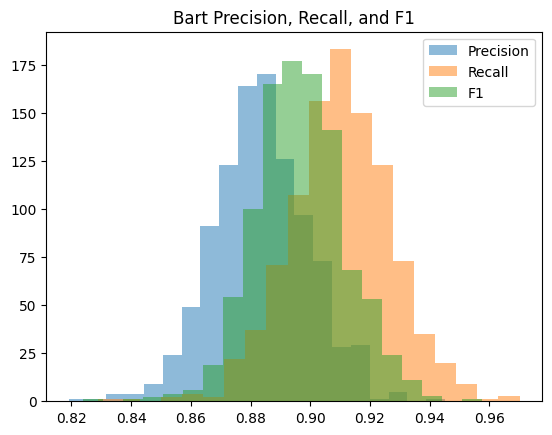

In [21]:
# plot the t5_precision, t5_recall, and t5_f1 scores in the same plot
plt.hist(df_sample["bart_precision"], bins=20, alpha=0.5, label="Precision")
plt.hist(df_sample["bart_recall"], bins=20, alpha=0.5, label="Recall")
plt.hist(df_sample["bart_f1"], bins=20, alpha=0.5, label="F1")
plt.legend(loc="upper right")
plt.title("Bart Precision, Recall, and F1")
plt.show()

In [26]:
# change t5_precision, t5_recall, and t5_f1 to t5_base_precision, t5_base_recall, and t5_base_f1
df_sample.rename(
    columns={
        "t5_precision": "t5_base_precision",
        "t5_recall": "t5_base_recall",
        "t5_f1": "t5_base_f1",
    },
    inplace=True,
)

In [27]:
df_sample

,articles,summaries,t5_summ,t5_base_precision,t5_base_recall,t5_base_f1,bart_summ,bart_precision,bart_recall,bart_f1
0,S Korea spending boost to economySouth Korea w...,"""The focus will be on job creation and economi...",South Korea to boost spending next year to cre...,0.900553,0.829235,0.863424,S Korea earmarks 100 trillion won ($96bn) for ...,0.887435,0.917885,0.902404
1,Slowdown hits US factory growthUS industrial p...,"""February was another good month in the manufa...",U.S. industrial output rises for 21st month in...,0.876172,0.821718,0.848072,The Institute for Supply Management (ISM) inde...,0.868801,0.939531,0.902783
2,Anti-terror plan faces first testPlans to allo...,Mr Clarke says he does not intend to use the h...,Home Secretary Charles Clarke says he doesn't ...,0.916732,0.815676,0.863256,"Tories, Lib Dems and some Labour MPs are poise...",0.894564,0.916578,0.905437
3,Barclays shares up on merger talkShares in UK ...,Shares in UK banking group Barclays have risen...,Barclays shares rise after weekend report that...,0.910849,0.812494,0.858865,Shares in UK banking group Barclays have risen...,0.890311,0.919583,0.904710
4,Building giant in asbestos payoutAustralian bu...,"In 2001, the company set up a fund to compensa...",Building giant James Hardie agrees to pay $1.1...,0.913028,0.846419,0.878462,The landmark deal could see thousands of peopl...,0.882196,0.908943,0.895370
...,...,...,...,...,...,...,...,...,...,...
995,TV show unites Angolan familiesAngolan familie...,"The media in the southern African country, twi...",A hugely popular TV show has reunited hundreds...,0.850907,0.806073,0.827884,Meeting Point has become one of TV Angola's mo...,0.881942,0.894574,0.888213
996,Whitehall cuts 'ahead of target'Thousands of c...,"In his Budget statement, the chancellor said t...",Thousands of civil service jobs have been cut ...,0.893641,0.841107,0.866578,"Chancellor Gordon Brown said 12,500 jobs had g...",0.859468,0.871821,0.865600
997,Snow Patrol bassist exits groupSnow Patrol had...,"Snow Patrol had ""no other course of action"" bu...",Snow Patrol co-founder and bassist Mark McClel...,0.895668,0.833395,0.863410,Mark McClelland had been in the band for more ...,0.870517,0.885658,0.878022
998,Da Vinci Code is 'lousy history'The plot of an...,Despite enjoying Dan Brown's conspiracy theory...,"The Da Vinci Code is 'lousy history', a clergy...",0.877299,0.830222,0.853112,The Da Vinci Code claims Jesus was not crucifi...,0.865914,0.888992,0.877301


In [30]:
df_sample.describe()

,t5_base_precision,t5_base_recall,t5_base_f1,bart_precision,bart_recall,bart_f1
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,0.895370,0.823968,0.858023,0.883448,0.910341,0.896641
std,0.030876,0.021416,0.023234,0.016037,0.017182,0.015147
min,0.766658,0.701117,0.758127,0.819067,0.828827,0.823918
25%,0.874273,0.809877,0.842542,0.873043,0.899850,0.886596
50%,0.896378,0.823550,0.858866,0.883088,0.910939,0.895977
75%,0.916930,0.837796,0.873382,0.893789,0.921396,0.905915
max,0.972600,0.918206,0.944621,0.945142,0.970135,0.957476


In [40]:
text = df_sample["articles"][0]
reference_summary = df_sample["summaries"][0]
print(text)

S Korea spending boost to economySouth Korea will boost state spending next year in an effort to create jobs and kick start its sputtering economy.It has earmarked 100 trillion won ($96bn) for the first six months of 2005, 60% of its total annual budget. The government's main problems are "slumping consumption and a contraction in the construction industry". It aims to create 400,000 jobs and will focus on infrastructure and home building, as well as providing public firms with money to hire new workers.The government has set an economic growth rate target of 5% for next year and hinted that would be in danger unless it took action. "Internal and external economic conditions are likely to remain unfavourable in 2005," the Finance and Economy Ministry said in a statement.It blamed "continuing uncertainties such as fluctuating oil prices and foreign exchange rates and stagnant domestic demand that has shown few signs of a quick rebound". In 2004, growth will be between 4.7% and 4.8%, the

In [41]:
# try t5 summarization and bart on one article


print("T5 summarization: \n")
t5_summarized = getSummary(text, t5_summ)
print(t5_summarized)

print("Bart summarization: \n")
bart_summarized = getSummary(text, bart_summ)
print(bart_summarized)

T5 summarization: 

South Korea to boost spending next year to create jobs and kick start its sputtering economy - says finance minister - and warns it could be in danger
Bart summarization: 

S Korea earmarks 100 trillion won ($96bn) for first six months of 2005. Government's main problems are "slumping consumption and a contraction in the construction industry" It aims to create 400,000 jobs and will focus on infrastructure and home building. Not everyone is convinced the plan will work.


In [28]:
df_sample.to_csv("t5_bart_bert_score.csv", index=False)

In [46]:
df_sample["pegasus_summ"] = df_sample["articles"].apply(
    lambda x: getSummary_chunks(x, pegasus_summ)
)

Your max_length is set to 256, but your input_length is only 98. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=49)
Your max_length is set to 256, but your input_length is only 94. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=47)
Your max_length is set to 256, but your input_length is only 98. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=49)
Your max_length is set to 256, but your input_length is only 98. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=49)
Your

In [47]:
df_sample

,articles,summaries,t5_summ,t5_base_precision,t5_base_recall,t5_base_f1,bart_summ,bart_precision,bart_recall,bart_f1,pegasus_summ
0,S Korea spending boost to economySouth Korea w...,"""The focus will be on job creation and economi...",South Korea to boost spending next year to cre...,0.900553,0.829235,0.863424,S Korea earmarks 100 trillion won ($96bn) for ...,0.887435,0.917885,0.902404,"It aims to create 400,000 jobs and will focus ..."
1,Slowdown hits US factory growthUS industrial p...,"""February was another good month in the manufa...",U.S. industrial output rises for 21st month in...,0.876172,0.821718,0.848072,The Institute for Supply Management (ISM) inde...,0.868801,0.939531,0.902783,"""February was another good month in the manufa..."
2,Anti-terror plan faces first testPlans to allo...,Mr Clarke says he does not intend to use the h...,Home Secretary Charles Clarke says he doesn't ...,0.916732,0.815676,0.863256,"Tories, Lib Dems and some Labour MPs are poise...",0.894564,0.916578,0.905437,Anti-terror plan faces first testPlans to allo...
3,Barclays shares up on merger talkShares in UK ...,Shares in UK banking group Barclays have risen...,Barclays shares rise after weekend report that...,0.910849,0.812494,0.858865,Shares in UK banking group Barclays have risen...,0.890311,0.919583,0.904710,Barclays shares up on merger talkShares in UK ...
4,Building giant in asbestos payoutAustralian bu...,"In 2001, the company set up a fund to compensa...",Building giant James Hardie agrees to pay $1.1...,0.913028,0.846419,0.878462,The landmark deal could see thousands of peopl...,0.882196,0.908943,0.895370,Building giant in asbestos payoutAustralian bu...
...,...,...,...,...,...,...,...,...,...,...,...
995,TV show unites Angolan familiesAngolan familie...,"The media in the southern African country, twi...",A hugely popular TV show has reunited hundreds...,0.850907,0.806073,0.827884,Meeting Point has become one of TV Angola's mo...,0.881942,0.894574,0.888213,"Every Friday, hundreds of people gather in Lua..."
996,Whitehall cuts 'ahead of target'Thousands of c...,"In his Budget statement, the chancellor said t...",Thousands of civil service jobs have been cut ...,0.893641,0.841107,0.866578,"Chancellor Gordon Brown said 12,500 jobs had g...",0.859468,0.871821,0.865600,Unions oppose the plans but Mr Brown said £2bn...
997,Snow Patrol bassist exits groupSnow Patrol had...,"Snow Patrol had ""no other course of action"" bu...",Snow Patrol co-founder and bassist Mark McClel...,0.895668,0.833395,0.863410,Mark McClelland had been in the band for more ...,0.870517,0.885658,0.878022,Snow Patrol bassist exits groupSnow Patrol had...
998,Da Vinci Code is 'lousy history'The plot of an...,Despite enjoying Dan Brown's conspiracy theory...,"The Da Vinci Code is 'lousy history', a clergy...",0.877299,0.830222,0.853112,The Da Vinci Code claims Jesus was not crucifi...,0.865914,0.888992,0.877301,Da Vinci Code is 'lousy history'The plot of an...


In [48]:
from bert_score import score
from tqdm import tqdm
import numpy as np

# Create columns for precision, recall, and F1 score
df_sample["pegasus_precision"] = np.nan
df_sample["pegasus_recall"] = np.nan
df_sample["pegasus_f1"] = np.nan

for i, row in tqdm(df_sample.iterrows(), total=len(df_sample)):
    precision, recall, f1 = score(
        [row["pegasus_summ"]], [row["summaries"]], lang="en", verbose=False
    )
    df_sample.at[i, "pegasus_precision"] = precision.item()
    df_sample.at[i, "pegasus_recall"] = recall.item()
    df_sample.at[i, "pegasus_f1"] = f1.item()

  0%|          | 0/1000 [00:00<?, ?it/s]Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
  0%|          | 1/1000 [00:06<1:52:31,  6.76s/it]Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
  0%|          | 2/1000 [00:08<1:04:42,  3.89s/it]Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions

In [49]:
df_sample.to_csv("t5_bart_pegasus_bert_score.csv", index=False)

In [50]:
df_sample

,articles,summaries,t5_summ,t5_base_precision,t5_base_recall,t5_base_f1,bart_summ,bart_precision,bart_recall,bart_f1,pegasus_summ,pegasus_precision,pegasus_recall,pegasus_f1
0,S Korea spending boost to economySouth Korea w...,"""The focus will be on job creation and economi...",South Korea to boost spending next year to cre...,0.900553,0.829235,0.863424,S Korea earmarks 100 trillion won ($96bn) for ...,0.887435,0.917885,0.902404,"It aims to create 400,000 jobs and will focus ...",0.884309,0.891704,0.887991
1,Slowdown hits US factory growthUS industrial p...,"""February was another good month in the manufa...",U.S. industrial output rises for 21st month in...,0.876172,0.821718,0.848072,The Institute for Supply Management (ISM) inde...,0.868801,0.939531,0.902783,"""February was another good month in the manufa...",0.908699,0.865106,0.886367
2,Anti-terror plan faces first testPlans to allo...,Mr Clarke says he does not intend to use the h...,Home Secretary Charles Clarke says he doesn't ...,0.916732,0.815676,0.863256,"Tories, Lib Dems and some Labour MPs are poise...",0.894564,0.916578,0.905437,Anti-terror plan faces first testPlans to allo...,0.902200,0.932260,0.916984
3,Barclays shares up on merger talkShares in UK ...,Shares in UK banking group Barclays have risen...,Barclays shares rise after weekend report that...,0.910849,0.812494,0.858865,Shares in UK banking group Barclays have risen...,0.890311,0.919583,0.904710,Barclays shares up on merger talkShares in UK ...,0.946840,0.946534,0.946687
4,Building giant in asbestos payoutAustralian bu...,"In 2001, the company set up a fund to compensa...",Building giant James Hardie agrees to pay $1.1...,0.913028,0.846419,0.878462,The landmark deal could see thousands of peopl...,0.882196,0.908943,0.895370,Building giant in asbestos payoutAustralian bu...,0.881625,0.891191,0.886382
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,TV show unites Angolan familiesAngolan familie...,"The media in the southern African country, twi...",A hugely popular TV show has reunited hundreds...,0.850907,0.806073,0.827884,Meeting Point has become one of TV Angola's mo...,0.881942,0.894574,0.888213,"Every Friday, hundreds of people gather in Lua...",0.888484,0.870999,0.879655
996,Whitehall cuts 'ahead of target'Thousands of c...,"In his Budget statement, the chancellor said t...",Thousands of civil service jobs have been cut ...,0.893641,0.841107,0.866578,"Chancellor Gordon Brown said 12,500 jobs had g...",0.859468,0.871821,0.865600,Unions oppose the plans but Mr Brown said £2bn...,0.865520,0.893417,0.879247
997,Snow Patrol bassist exits groupSnow Patrol had...,"Snow Patrol had ""no other course of action"" bu...",Snow Patrol co-founder and bassist Mark McClel...,0.895668,0.833395,0.863410,Mark McClelland had been in the band for more ...,0.870517,0.885658,0.878022,Snow Patrol bassist exits groupSnow Patrol had...,0.933798,0.940098,0.936938
998,Da Vinci Code is 'lousy history'The plot of an...,Despite enjoying Dan Brown's conspiracy theory...,"The Da Vinci Code is 'lousy history', a clergy...",0.877299,0.830222,0.853112,The Da Vinci Code claims Jesus was not crucifi...,0.865914,0.888992,0.877301,Da Vinci Code is 'lousy history'The plot of an...,0.866730,0.895710,0.880982


In [51]:
df_sample.describe()

,t5_base_precision,t5_base_recall,t5_base_f1,bart_precision,bart_recall,bart_f1,pegasus_precision,pegasus_recall,pegasus_f1
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,0.895370,0.823968,0.858023,0.883448,0.910341,0.896641,0.902176,0.898644,0.900306
std,0.030876,0.021416,0.023234,0.016037,0.017182,0.015147,0.025065,0.024863,0.023057
min,0.766658,0.701117,0.758127,0.819067,0.828827,0.823918,0.814076,0.804941,0.818751
25%,0.874273,0.809877,0.842542,0.873043,0.899850,0.886596,0.884754,0.881609,0.885051
50%,0.896378,0.823550,0.858866,0.883088,0.910939,0.895977,0.901574,0.898178,0.901029
75%,0.916930,0.837796,0.873382,0.893789,0.921396,0.905915,0.918608,0.915348,0.915172
max,0.972600,0.918206,0.944621,0.945142,0.970135,0.957476,0.987588,0.967541,0.967991
